In [8]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define geometry of single element model

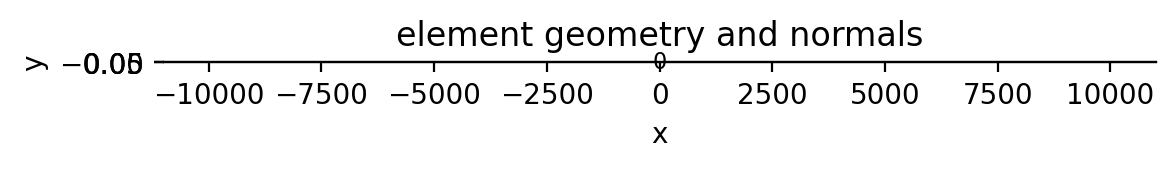

In [9]:
# List of elements for forward model
n_els = 1
mu = 3e10
nu = 0.25
L = 10000
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_els)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

# Observation coordinates

In [10]:
n_pts = 100
width = 20000
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Single constant slip element

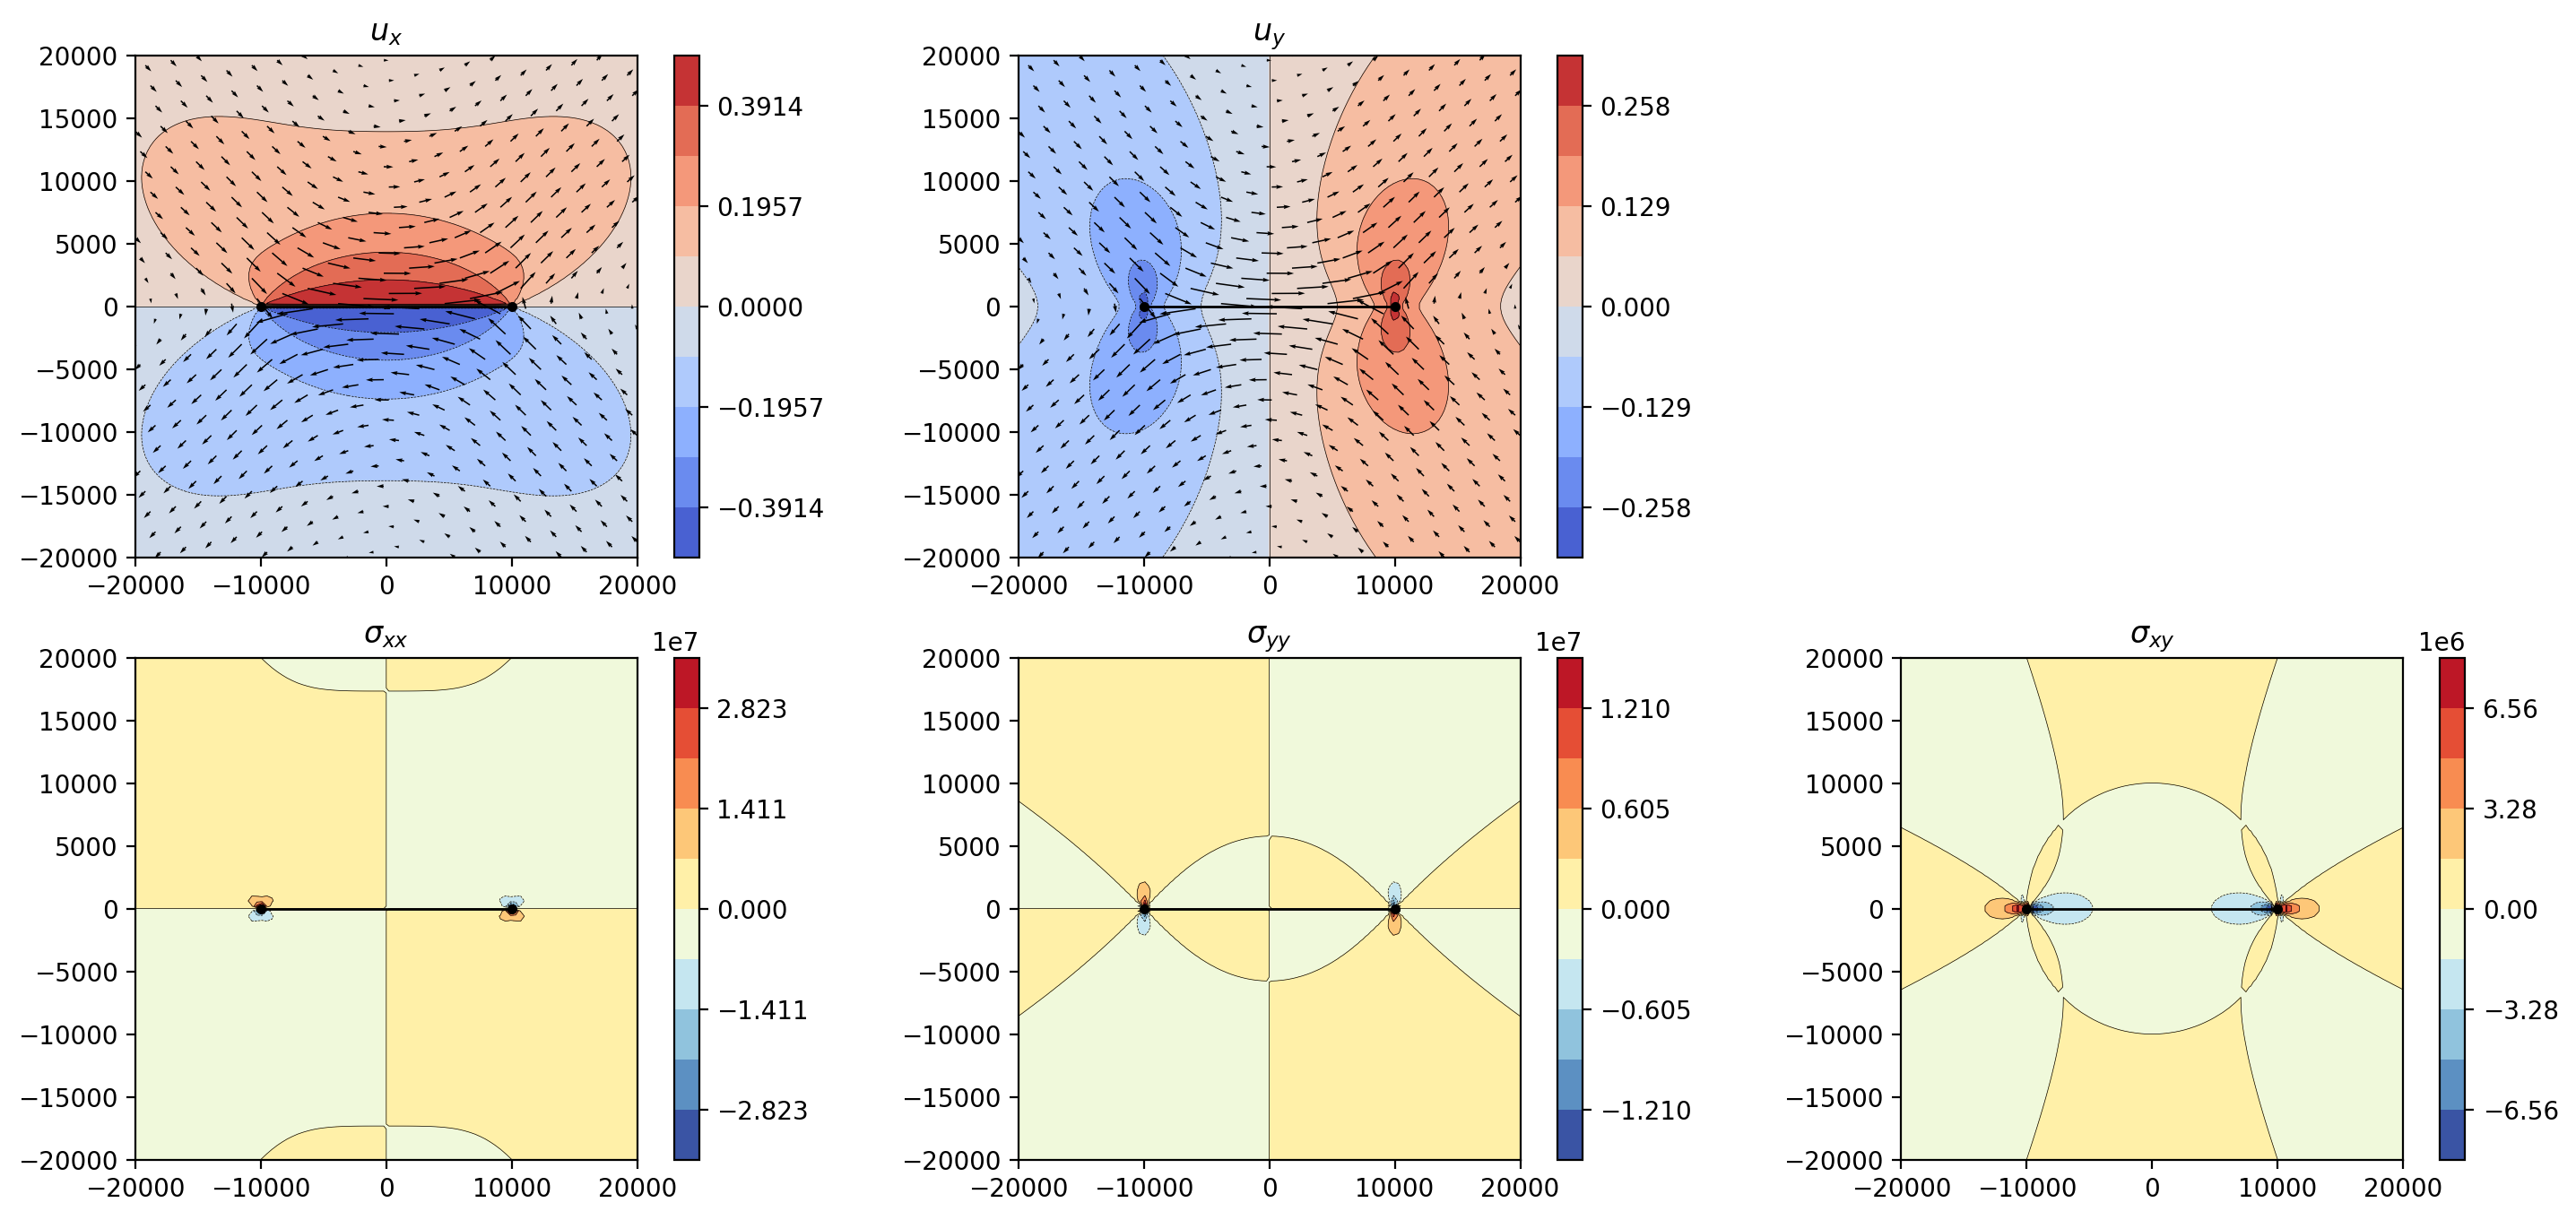

In [11]:
strike_slip_constant = 1
tensile_slip_constant = 0

(
    displacement_constant,
    stress_constant,
) = bemcs.displacements_stresses_constant_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_constant,
    tensile_slip_constant,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_constant[0, :]
uy = displacement_constant[1, :]
sxx = stress_constant[0, :]
syy = stress_constant[1, :]
sxy = stress_constant[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)

# Calculate and plot strain energy

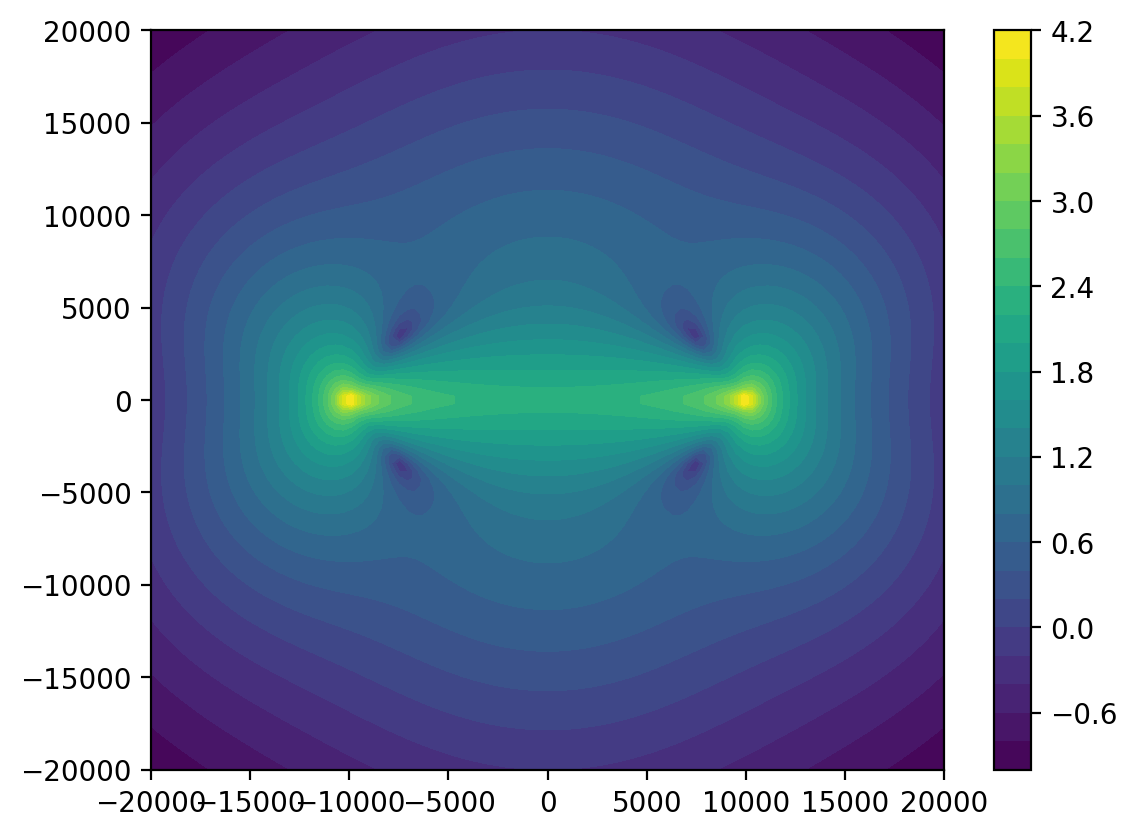

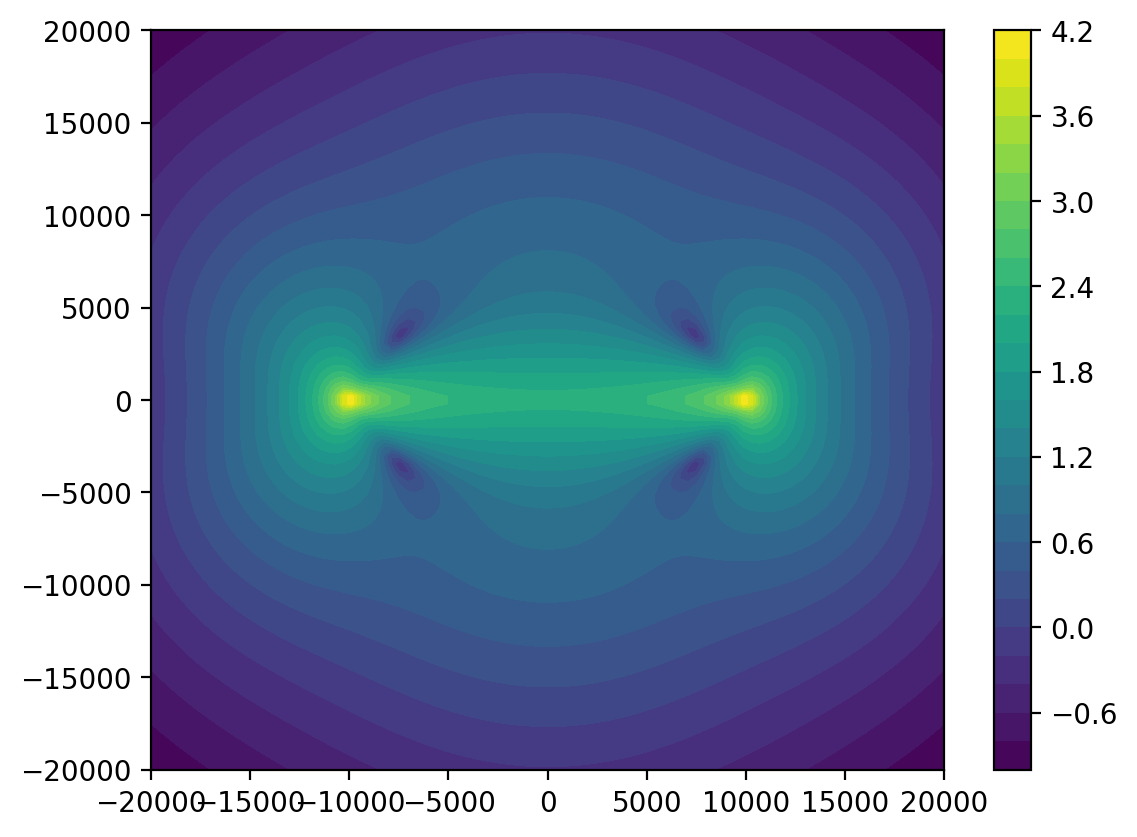

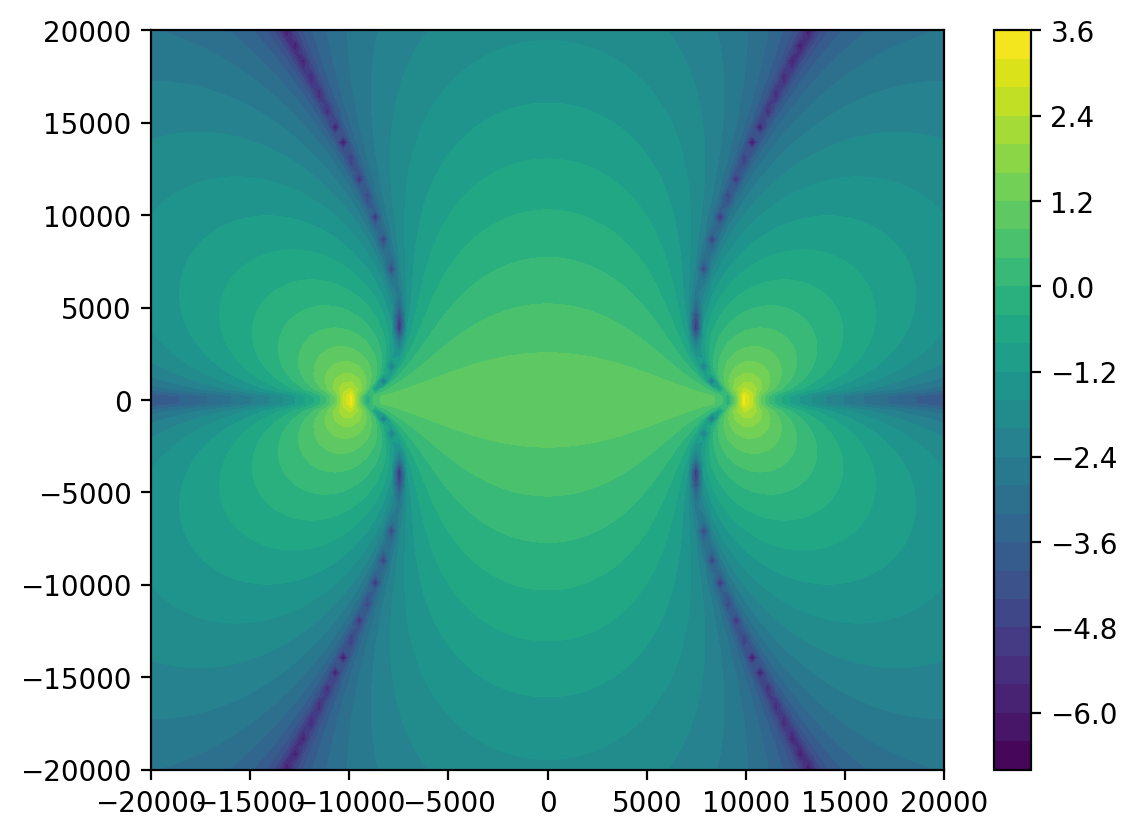

In [47]:
# Calculate strain from stress...strange times
youngs_modulus = 2 * mu * (1 + nu)
# Plane strain linear operator
temp = (
    youngs_modulus
    / ((1 + nu) * (1 - 2 * nu))
    * np.array([[1 - nu, nu, 0], [nu, 1 - nu, 0], [0, 0, (1 - 2 * nu) / 2.0]])
)
strains_from_stress_plane_strain = np.linalg.inv(temp)

# Plane stress linear operator
strains_from_stress_plane_stress = (
    1 / youngs_modulus * np.array([[1, -nu, 0], [-nu, 1, 0], [0, 0, 2 * (1 + nu)]])
)
exx = np.zeros_like(sxx)
exy = np.zeros_like(syy)
eyy = np.zeros_like(sxy)
exx1 = np.zeros_like(sxx)
exy1 = np.zeros_like(syy)
eyy1 = np.zeros_like(sxy)


for i in range(len(sxx)):
    stresses = np.array([sxx[i], syy[i], sxy[i]])
    exx[i], eyy[i], exy[i] = strains_from_stress_plane_stress @ stresses
    exx1[i], eyy1[i], exy1[i] = strains_from_stress_plane_strain @ stresses


# Calculate strain energy
strain_energy = sxx * exx + syy * eyy + sxy * exy
strain_energy1 = sxx * exx1 + syy * eyy1 + sxy * exy1

# Plt strain energy
plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    np.log10(np.abs(strain_energy.reshape(n_pts, n_pts))),
    levels=30,
)
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    np.log10(np.abs(strain_energy1.reshape(n_pts, n_pts))),
    levels=30,
)
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    np.log10(
        np.abs(
            strain_energy.reshape(n_pts, n_pts) - strain_energy1.reshape(n_pts, n_pts)
        )
    ),
    levels=30,
)
plt.colorbar()
plt.show()